<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image
import sys


In the last notebook, we finished getting a basic handle on SDRs. We are now ready to start using htm.core a little, and also I will take the opportunity to clean up functions that I have created. 

We have some funtions that are to create SDRs, create noise. Let's first group the functions, to clean up mostly around making the visualisation, to pass SDRs of any size and getting coordinates. From here will start to build out a code base but also show along the way how we can use something more sophisticated. It seems a right of passage in HTM to build your own implementation, so we will use code for that, but htm.core will be what you want for production.

I will also start to look at various functions in the htm.core so we can use similiar types of language as we build things. 

Everything here is quite similiar, I made the visualise function more general so it can take SDRs of different sizes and also can be used for encoders

In [2]:
#################### SINGLE SDR FUNCTIONS ###################################################


def create_randomised_sdr(capacity, population):
    sdr = set()
    
    while len(sdr) < population:
        sdr.add(np.random.randint(low=1, high=capacity))

    return(list(sdr))


def randomly_flip_percentage_of_bits(SDR, array_size, percentage_to_flip):
    to_remove = int(percentage_to_flip * len(SDR))
    randomised_SDR = np.random.shuffle(SDR)
    del SDR[0:to_remove]
    noise = create_randominsed_sdr(np.sqrt(array_size), np.sqrt(array_size), to_remove)
    sdr_with_noise = noise + SDR
    return(sdr_with_noise)



############## MULTIPLE SDR FUNCTIONS ###################################################
def compute_union_and_overlap(SDR1_on_bits, SDR2_on_bits):
    union = list(set(SDR1_on_bits).union(SDR2_on_bits))
    overlap = list(set(SDR1_on_bits).intersection(SDR2_on_bits))
    
    return({"union": union, "overlap": overlap})

def create_and_compare_sdrs_over_multiple_iterations(iterations, sdr_size, population):
    sdr_unions_for_comparison = []
    sdr_overlaps_for_comparison = []
    for x in range(iterations):
        SDR1 = create_randominsed_sdr(sdr_size, population)
        SDR2 =create_randominsed_sdr(sdr_size, population)
        sdr_comparison = compute_union_and_overlap(SDR1, SDR2)
        sdr_unions_for_comparison.append(len(sdr_comparison['union']))
        sdr_overlaps_for_comparison.append(len(sdr_comparison['overlap']))
    print("Average union: ", str(sum(sdr_unions_for_comparison) / len(sdr_unions_for_comparison)))
    print("Average overlap: ", str(sum(sdr_overlaps_for_comparison) / len(sdr_overlaps_for_comparison)))
    return({"union_comparison": sdr_unions_for_comparison, "overlap_comparison": sdr_overlaps_for_comparison})

def compute_overlap_set_cardinality(n, w0, w1, b, provide_summary = True):
    on_bit_space = sp.binomial(w0, b)
    off_bit_space = sp.binomial(n - w0, w1 - b)
    overlap_set = on_bit_space * off_bit_space
    if provide_summary:
        print("Given a capcity of", str(w0), "bits in the on-bit space, the number of ways to arrange ", str(b), "on-bits: ", on_bit_space)
        print("Given a capacity", str(n - w0), "bits in the off-bit space, the number of ways to arrange", str(w1 - b), "off-bits: ", off_bit_space)
        print("Number of SDRs that will match w0: ", overlap_set)
    return(overlap_set)

######################## VISUALISATION FUNCTIONS ############################################


def create_axis_for_sdr(ax, x_limit, y_limit, population, label, create_label = True):
    
    if create_label:
        label_add = np.round((population / (x_limit * y_limit)) * 100, 2)
        label = label + ' (Sparsity: {}%)'.format(label_add)
        ax.set_xlabel(label)
        
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.5)
    
    return(ax)


def convert_sdr_to_tuple_for_visualisation(sdr, sdr_size):    
    counting_offset = 1
    # create array of complete sdrs

    m = np.zeros(sdr_size)
    for i in sdr:
        m[i] = m[i] + 1
    
    # find dimensions of visualisation
    n = sp.symbols('n')
    e = sp.Eq(2**n, sdr_size)
    s = sp.solve(e, n)
    middle_index = np.floor(float(s[0] / 2))
    
    if s[0] % 2 == 0:
        dimensions = [2**middle_index, 2**middle_index]
    else:
        dimensions = [2**middle_index, 2**(middle_index + 1)]
    
    d = np.reshape(m, [int(v) for v in dimensions])
    v = np.where(d == 1)

    
    coords = [(v[1][i], (dimensions[1] - counting_offset) - v[0][i]) for i in range(len(v[1]))]
    
    return(coords)


Let's test our code so far a little: 

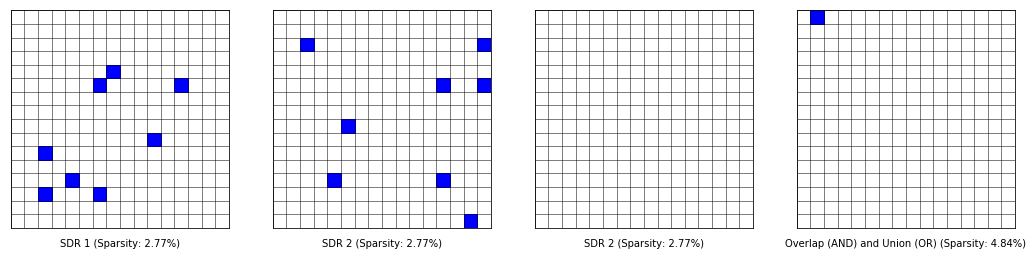

In [3]:
sdr_size = 256
population = 8
#label = str(np.round(sdr_size/population, 3))

specs1 = create_randomised_sdr(sdr_size, population)
specs2 = create_randomised_sdr(sdr_size, population)

x_vals, y_vals = sdr_comparison = compute_union_and_overlap(specs1, specs2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")
ax2 = create_axis_for_sdr(ax2, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax3 = create_axis_for_sdr(ax3, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax4 = create_axis_for_sdr(ax4, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, len(sdr_comparison['union']), "Overlap (AND) and Union (OR)")


SDR1 = [ax1.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs1))]
SDR2 = [ax2.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs2, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs2))]
SDR3 = ax4.add_patch(Rectangle([1,15], 1, 1, color="blue"))
#union = [ax3.add_patch(Rectangle(sdr_comparison['union'][i], 1, 1, color="gray")) for i in range(len(sdr_comparison['union']))]
# overlap = [ax3.add_patch(Rectangle(sdr_comparison['overlap'][i], 1, 1, color="orange")) for i in range(len(sdr_comparison['overlap']))]


Looks like things still work. Now let's move on to the idea of an encoder. THer is a videa for this which is very handy, we know that SDRs are a powerful way to get data, but how do take data that we experience in the real world and put it into this format. Start with the HTM shcool video: 

In [4]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V3Yqtpytif0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

At this point to we are going to start uisng the BAMI resource found at: [HERE]

1. Semantically similar data should result in SDRs with overlapping active bits.

2. The same input should always produce the same SDR as output.

3. The output should have the same dimensionality (total number of bits) for all inputs.

4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and
    subsampling.
    


Let's build an encorder and start with numbers, numbers are bit overly simple. For an input space a grid like above, how many buckets can 


To get a sense of an ecoder, let's build it as a Python class. Its kind of an object type of thing, so let's treat it that way. This enoder will set up the size of the bit space, know how many buckets, and provide values back. We can create one and then work through the functions: 

In [5]:
## JG - min max should be about accepted input signals, 

## but can imput anything avoe and beyond which should be clipped


class CreateEncoder:
    def __init__(self, bit_space_size = None,
                number_of_bits_per_value = None,
                min_val = None,
                max_val = None):
        self.bit_space_size = bit_space_size
        self.number_of_bits_per_value = number_of_bits_per_value
        self.unique_bits_per_encoded_value = 1
        self.min_value_to_encode = min_val
        self.max_value_to_encode = max_val
        self.buckets = self.compute_bucket_capacity(self.bit_space_size, self.number_of_bits_per_value)
        self.max_bucket_starting_indice = self.buckets - 1
        self.offset = 1
        self.current_encoded_value = None
        self.bit_locations_for_current_encoded_value = 1
        self.previously_encoded_values = np.array([])
        self.bit_locations_for_previously_encoded_values = []
        self.current_and_previous_encoded_values_comparison = None
        self.is_periodic = False
        
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("Bit Space Size: ", self.bit_space_size)
        print("Number of bits used to encode each value:", self.number_of_bits_per_value)
        print("Range of values to be encoded: From ", self.min_value_to_encode, ' to ', self.max_value_to_encode)
        print("Number of unique bits per encoded value: ", self.unique_bits_per_encoded_value)
        print("Number of buckets available in bit space:", self.buckets)
        print("Max bucket starting indice:", self.max_bucket_starting_indice)
        print("Current encoded value: ", self.current_encoded_value)
        print("Previously encoded values: ", self.previously_encoded_values)
        print("Bit locations for current encoded value: ", self.bit_locations_for_current_encoded_value)
        print("Bit locations for previously encoded values: ", self.bit_locations_for_previously_encoded_values)
        print("Current and previous encoded values comparison: ", self.current_and_previous_encoded_values_comparison)
        print("Encode periodically: ", self.is_periodic)
    
    def compute_bucket_capacity(self, n, w):
        return(n - w + 1)

    def compare_current_and_previously_encoded_value(self):
        self.current_and_previous_encoded_values_comparison = np.abs(self.current_encoded_value / self.bit_space_size - self.previously_encoded_values[0] / self.bit_space_size)
    
    def encode_value_in_bit_space(self, value_choice):
        
        # check if value is outside range
        if (value_choice < self.min_value_to_encode) or (value_choice > self.max_value_to_encode):
            print('Not a valid value to encode as is outside specified range')
            return()
        
        if self.current_encoded_value is not None:
            self.previously_encoded_values = np.append(self.previously_encoded_values, self.current_encoded_value)
            self.bit_locations_for_previously_encoded_values.append(self.bit_locations_for_current_encoded_value)
            self.compare_current_and_previously_encoded_value()
        self.current_encoded_value = value_choice
        
        if (value_choice > self.max_bucket_starting_indice):
            value_to_encode = self.max_bucket_starting_indice
        else:
            value_to_encode = value_choice
            
        window = [value_to_encode, value_to_encode + self.number_of_bits_per_value - self.offset]
        all_values = np.arange(window[0], window[1] + self.offset)
        self.bit_locations_for_current_encoded_value = all_values
    

    


So my encoder has a bunch of functions. Note that, for now at least, we are not worried about efficienty, but simplicity. let's create an instance of it with some initial parameters and see what it can do:

In [6]:
# initial settings
b_size = 64
population = 5
min_value_to_encode = 0
max_value_to_encode = 100

# create encoder
encoder1 = CreateEncoder(bit_space_size = b_size,
                number_of_bits_per_value = population,
                min_val = min_value_to_encode,
                max_val = max_value_to_encode)
encoder1.get_summary()

----------------- SUMMARY -------------------------
Bit Space Size:  64
Number of bits used to encode each value: 5
Range of values to be encoded: From  0  to  100
Number of unique bits per encoded value:  1
Number of buckets available in bit space: 60
Max bucket starting indice: 59
Current encoded value:  None
Previously encoded values:  []
Bit locations for current encoded value:  1
Bit locations for previously encoded values:  []
Current and previous encoded values comparison:  None
Encode periodically:  False


Our encoder tells us it has some initial set up. The whole bit space appears to be 64, and any value that I would want to encode in this space will be 5 bits in length. If you think of this as an array with length 64, I can put 50 buckets (the first starting at index 1 of the array, the second starting at index two) into that space and its possible to encode 60 unique values. 

IMG

My initital settings however say that the range to from -10 to 100. So this will let me put any scalar, starting from -10 onwards, until I run out of buckets. After that, for any number I try and encode to the top of my range, it will just encode it to the very last bucket. We We can get around this by setting the encoder to periodic, which will do so later, or by just scaling back the range so the buckets can accomodate it. 

Note that the number of 50 buckets assumes that I have 1 unique bits per encoded value. So, for example, the value 8 and 9 starts at array indice 8 and 9 respectively, and 8 has 1 unique bit and the rest shared with adjacenct values. 

So now let's put some values into my encoder

In [7]:
encoder1.encode_value_in_bit_space(value_choice=5)
encoder1.encode_value_in_bit_space(value_choice=89)
encoder1.encode_value_in_bit_space(value_choice=42)
encoder1.encode_value_in_bit_space(value_choice=41)
encoder1.get_summary()

----------------- SUMMARY -------------------------
Bit Space Size:  64
Number of bits used to encode each value: 5
Range of values to be encoded: From  0  to  100
Number of unique bits per encoded value:  1
Number of buckets available in bit space: 60
Max bucket starting indice: 59
Current encoded value:  41
Previously encoded values:  [ 5. 89. 42.]
Bit locations for current encoded value:  [41 42 43 44 45]
Bit locations for previously encoded values:  [array([5, 6, 7, 8, 9]), array([59, 60, 61, 62, 63]), array([42, 43, 44, 45, 46])]
Current and previous encoded values comparison:  0.578125
Encode periodically:  False


In [8]:
encoder1.compare_current_and_previously_encoded_value()

I have encoded in order, 5, 61, 14 and 13. This leaves me a current encoded value of 13, and a bunch of previous values I have encoded. My encoder is holding onto these so we can to comparisons. 

Let's visualise this using the visualization functions we have already created: 

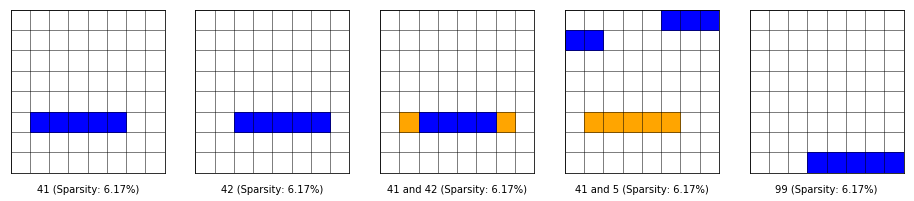

In [9]:

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 3))

ax1 = create_axis_for_sdr(ax1, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "41")
ax2 = create_axis_for_sdr(ax2, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "42")
ax3 = create_axis_for_sdr(ax3, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "41 and 42")
ax4 = create_axis_for_sdr(ax4, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "41 and 5")
ax5 = create_axis_for_sdr(ax5, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "99")

coords1 = convert_sdr_to_tuple_for_visualisation(encoder1.bit_locations_for_current_encoded_value, b_size)
coords2 = convert_sdr_to_tuple_for_visualisation(encoder1.bit_locations_for_previously_encoded_values[2], b_size)
coords3 = convert_sdr_to_tuple_for_visualisation(encoder1.bit_locations_for_previously_encoded_values[0], b_size)

union_and_overlap = compute_union_and_overlap(encoder1.bit_locations_for_current_encoded_value,encoder1.bit_locations_for_previously_encoded_values[2])

coords4 = convert_sdr_to_tuple_for_visualisation(union_and_overlap['union'], b_size)
coords5 = convert_sdr_to_tuple_for_visualisation(union_and_overlap['overlap'], b_size)

coords6 = convert_sdr_to_tuple_for_visualisation(encoder1.bit_locations_for_previously_encoded_values[1], b_size)


SDR1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color="blue")) for i in range(len(coords1))]
SDR2 = [ax2.add_patch(Rectangle(coords2[i], 1, 1, color="blue")) for i in range(len(coords2))]
SDR3 = [ax3.add_patch(Rectangle(coords4[i], 1, 1, color="orange")) for i in range(len(coords4))]
SDR3 = [ax3.add_patch(Rectangle(coords5[i], 1, 1, color="blue")) for i in range(len(coords5))]
SDR4 = [ax4.add_patch(Rectangle(coords1[i], 1, 1, color="orange")) for i in range(len(coords1))]
SDR4 = [ax4.add_patch(Rectangle(coords3[i], 1, 1, color="blue")) for i in range(len(coords3))]
SDR5 = [ax5.add_patch(Rectangle(coords6[i], 1, 1, color="blue")) for i in range(len(coords6))]


<div style="background:#99ddff; color:black; padding: 10px">
<b>Add to these notes:</b>

I want to keep these notes in HTML so I don't have to host on a server, but a great exceriise is to use the ipython widgets to experience this like it happens in the video. 
</div>

So we have 5 visualisations here: 41, 42, the overlap between then similiar and we can see this by looking at comparison. Ten for any value that is in our range but not buckets, we will just the max back, so the value 99. 

We can also consider how different. How different is 41 and 5. the simplest metric. The smallest difference is 1 and the max differece is difference betweeen first value and normalise this: 

$$\frac{59}{64} - \frac{1}{64}$$

This gives us a value between 0 and 1 that tells us about thier similiarity: 

In [13]:
encoder1.get_summary()

----------------- SUMMARY -------------------------
Bit Space Size:  64
Number of bits used to encode each value: 5
Range of values to be encoded: From  0  to  100
Number of unique bits per encoded value:  1
Number of buckets available in bit space: 60
Max bucket starting indice: 59
Current encoded value:  41
Previously encoded values:  [ 5. 89. 42.]
Bit locations for current encoded value:  [41 42 43 44 45]
Bit locations for previously encoded values:  [array([5, 6, 7, 8, 9]), array([59, 60, 61, 62, 63]), array([42, 43, 44, 45, 46])]
Current and previous encoded values comparison:  0.5625
Encode periodically:  False


So se can say that closer to zero the more similiar. This is not great, but it is just a linear score. In fact this encoder has lots of limiations, but it is a start. 

Before we go on to other types of encoders, let's spend some more time on the semantic similiarity measures, and formalise the rules we use a bit: 

These rules suppose we have some be an an arbitrary input space, $A$. In the space  $S(n, k)$ is a set of SDRs that each have the length n and each have k on bits. We are interested in encoding the semantic similiarity of any of the SDRs in this set, and we will call our semantic similarity measure $d_a$, a function that can be appled to a number of SDRs in a given input space.  

We define that our distance function needs to be able to fulfill 3 properties. Note also that, I am a not a big fan of using the word distance, and will probably swap this out, but for now it works well.

First rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, y) \ge 0 $$

This says, for any  in 2 SDRs in the set (here denoted as $x$ and $y$, the disntance function must return a value greater than or equal to zero. Proximity function

Second rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, y) \equiv d_A(x, y) $$

This says that our distance function must return the same output regardless, of the order we call our SDR in. So in teh example above, if we compute distance between 5 and 41, it is the same as computing distance for 41 and 5. 

Third rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, x) = 0 $$

This says that the distance from the SDR to itself must be the the same. So we are getting to the point where we can compare distnance and metric scores, and overlap. Let's make it a little more reigou

Let's define 1 more rule

Finally, we or union and overlap function could do with some work.Let's define a evaluation metric for an encoder

1. Let $O(s,t)$ be number of overlapping bits

For encoder $f: A \rightarrow S(n,k) $ and $\forall w, x, y,z \in A$:

$$O(f(w), f(x)) \ge O(f(y), f(z)) \equiv d_A(w, x) \le d_A (y, z)$$

So this tells that the overap score for 2 SDRs, $w$ and $x$ is greater than the overlap score for $y$ and $z$, the disance between $w$ and $x$ will be less than distance $y$ and $z$.

So we can desing metrics however we want, as long as they define these rules

In [14]:
def compute_union_and_overlap(SDR1_on_bits, SDR2_on_bits):
    union = list(set(SDR1_on_bits).union(SDR2_on_bits))
    overlap = list(set(SDR1_on_bits).intersection(SDR2_on_bits))
    
    return({"union": union, "overlap": overlap})
